# House Prices - Advanced Regression Techniques

## Deva Kulkarni, Jared Dec, Marc Semonick, Trevor Johnson

## October 2021

<br>

Competition Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Goal: Predict sales price for each house (`SalePrice`). RMSE on log(pred) - log(actual) will be the evaluation metric. 

Inference Problem:  Given known variables about a house, accurately predict its sale price.

Deliverable: Final submission dataset should contain only the two fields `ID` and `SalePrice`. 

# Setups

Import modules

In [44]:
# data manipulation/viz
import os 
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm 

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

Load in the data

In [45]:
# optional directory set-up
working_dir = !pwd
train = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "train.csv"))
test = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "test.csv"))
sample = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "sample_submission.csv"))

In [46]:
print("train shape: {}".format(train.shape))
print("test shape: {}".format(test.shape))

train shape: (1460, 81)
test shape: (1459, 80)


## Data cleaning

Deal with missing values

In [47]:
print("Count number of missing values per variable:")
print(train.isnull().sum()[train.isnull().sum() != 0])

# function to clean the missing values
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df

train = na_clean(train)
test = na_clean(test)

# make sure there are no more missing values
print("\nNumber of missing values after running na_clean()")
print("Missing values in train: {}".format(train.isnull().sum().sum()))
print("Missing values in test: {}".format(test.isnull().sum().sum()))

Count number of missing values per variable:
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Number of missing values after running na_clean()
Missing values in train: 0
Missing values in test: 0


# EDA

## Data Visualization

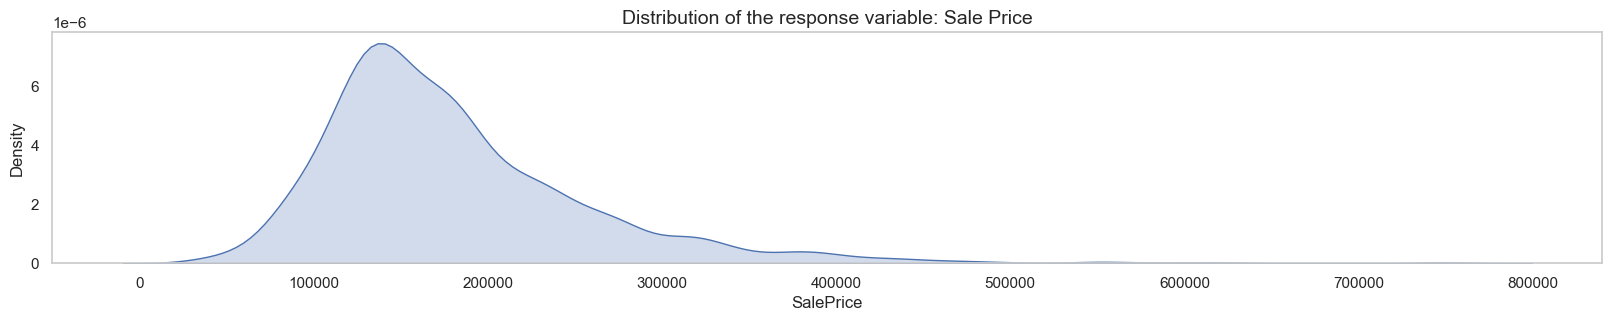

In [48]:
sns.set(rc = {'figure.figsize':(20,3)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.kdeplot(data=train, x="SalePrice", bw_adjust=.8, fill=True)\
    .set_title("Distribution of the response variable: Sale Price", size=14)
print("")

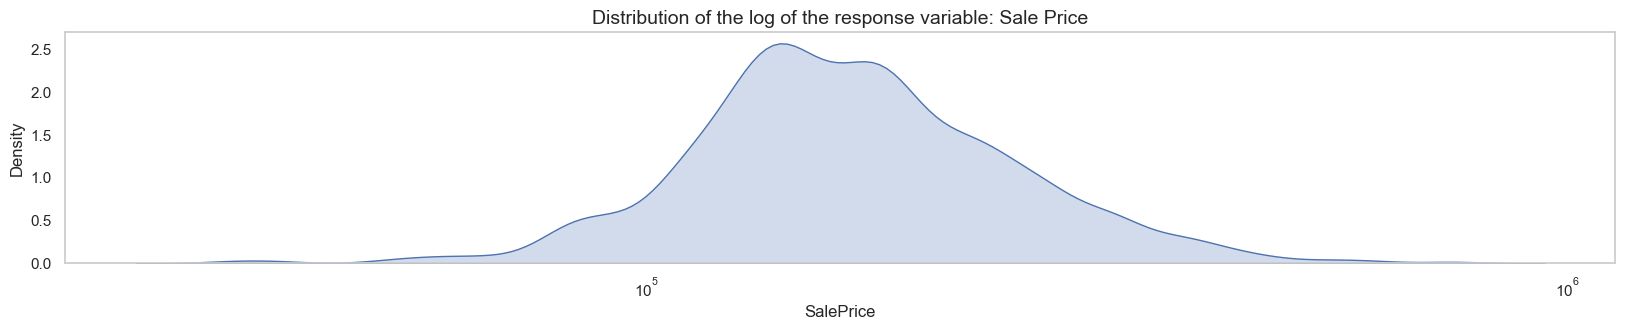

In [49]:
sns.set(rc = {'figure.figsize':(20,3)})
sns.set_style("whitegrid", {'axes.grid' : False})
sns.kdeplot(data=train, x="SalePrice", bw_adjust=.8, fill=True, log_scale=True)\
    .set_title("Distribution of the log of the response variable: Sale Price", size=14)
print("")

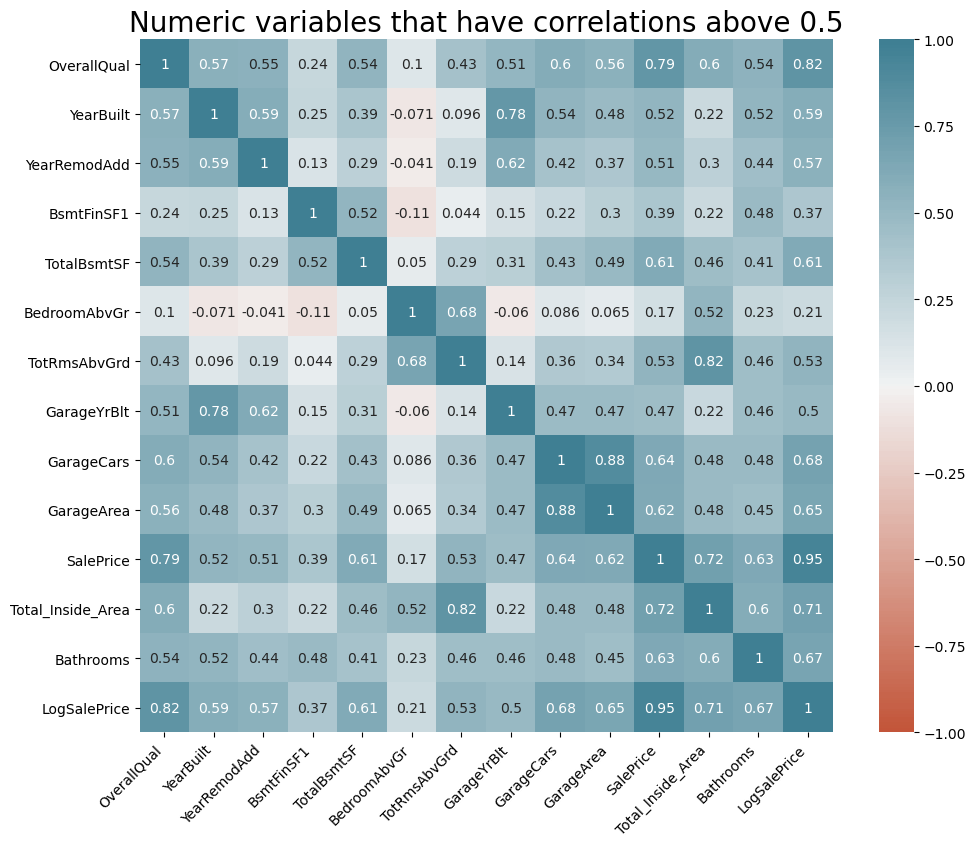

In [60]:
# get correlations of all numeric vars
corr_orig = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].corr()

# there are 38 of them, let's look at a subset to only show the ones w/ correlations above some threshold
threshold = .5
bool_list = [sum((corr_orig.iloc[i,:] < 1) & (corr_orig.iloc[i,:] > threshold)) > 0 for i in range(corr_orig.shape[0])]
corr = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))].loc[:, bool_list].corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmin=-1, center=0, vmax=1, annot=True, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title("Numeric variables that have correlations above {:.1f}".format(threshold), fontdict = {"fontsize": 20})


print("")

Scatterplot of every numeric variable vs the response variable

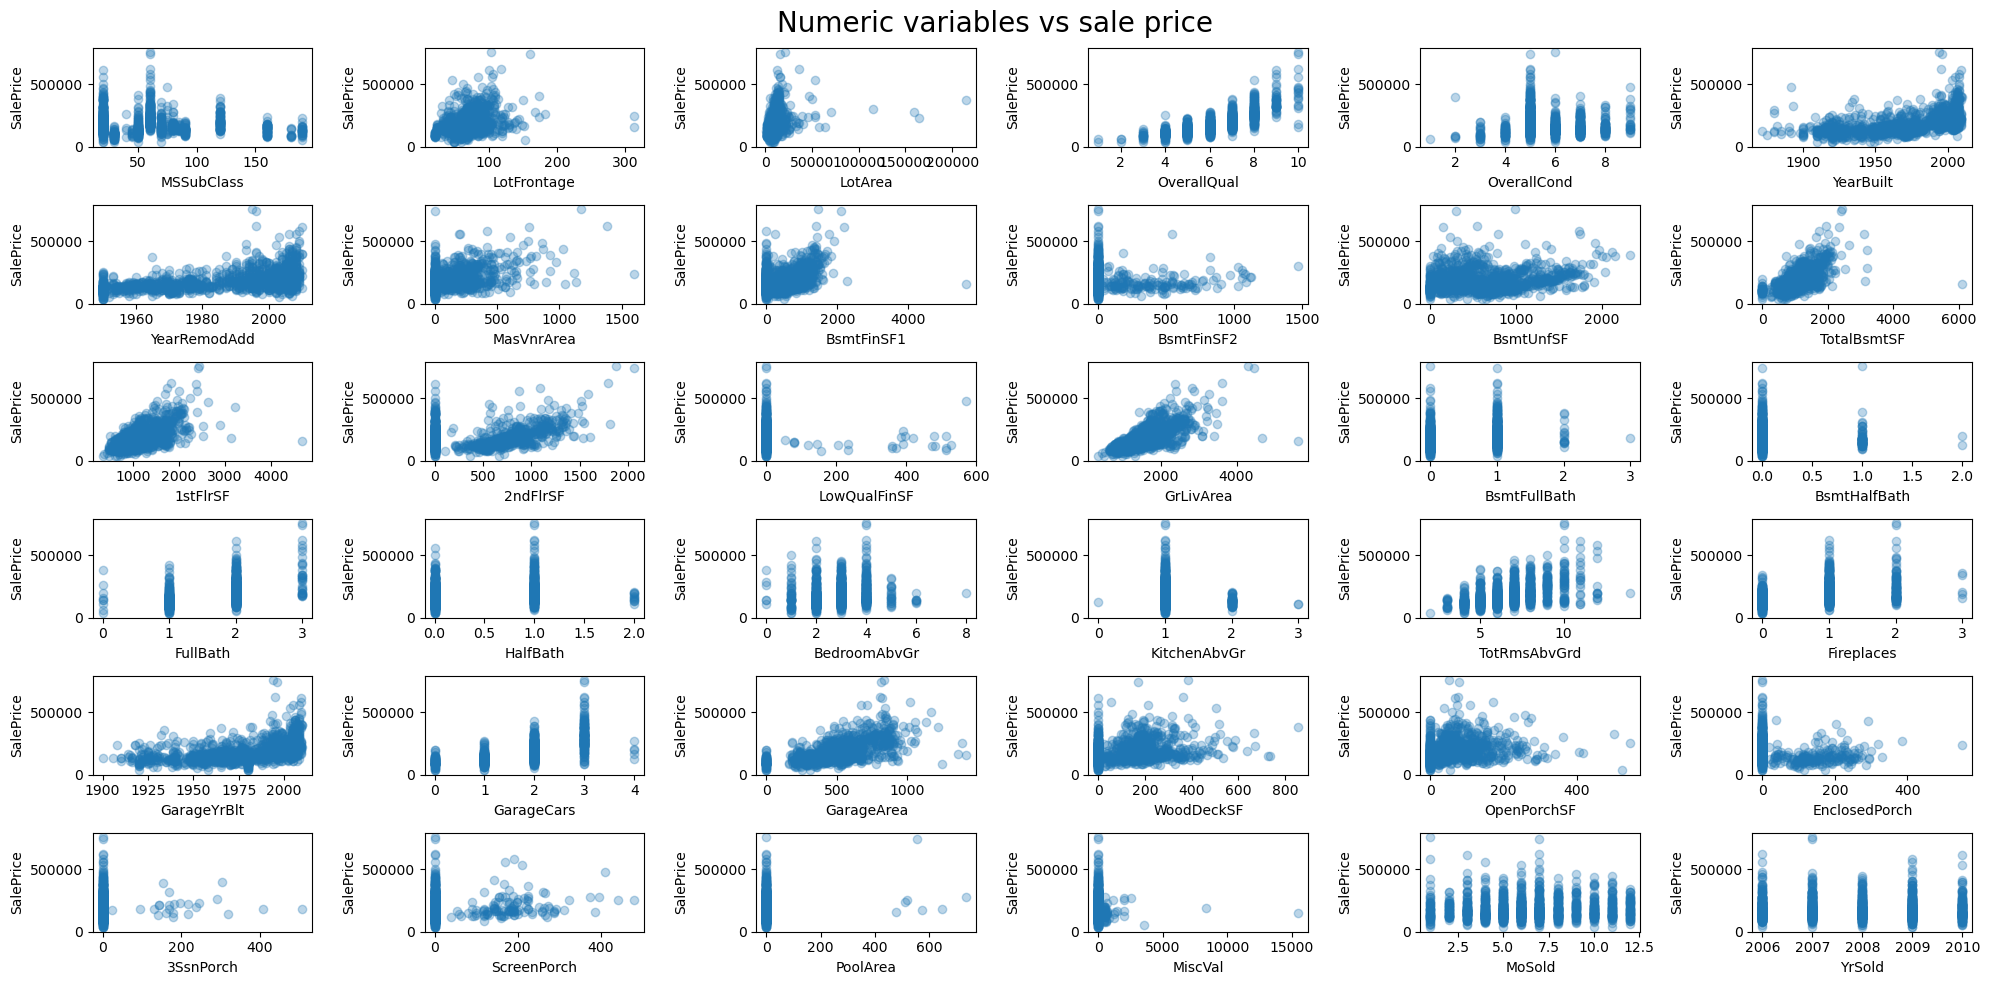

In [51]:
# scatter plots of all num vars w/ response var
num_vars = train.loc[:, (train.dtypes == type(1.0)) | (train.dtypes == type(1))]
num_vars = num_vars.drop(columns = ["Id"])

# plot in 6x6 grid to plot the 36 num vars against SalePrice
num_rows = 6
num_cols = 6
plt.style.use('default')
fig, ax = plt.subplots(num_rows, num_cols, figsize = (20, 10))

col_i = 0
for i in range(num_rows):
    for j in range(num_cols):
        if (num_vars.columns[col_i] == "SalePrice"):
            pass 
        else:
            ax[i][j].scatter(num_vars.iloc[:, col_i], num_vars['SalePrice'], alpha = .3)
            ax[i][j].set_xlabel(num_vars.columns[col_i])
            ax[i][j].set_ylabel("SalePrice")
            
            col_i += 1

fig.suptitle("Numeric variables vs sale price".format(col_i), size=20)
fig.tight_layout()
print("")

Bar charts showing the average sale price for every categorical variable factor level

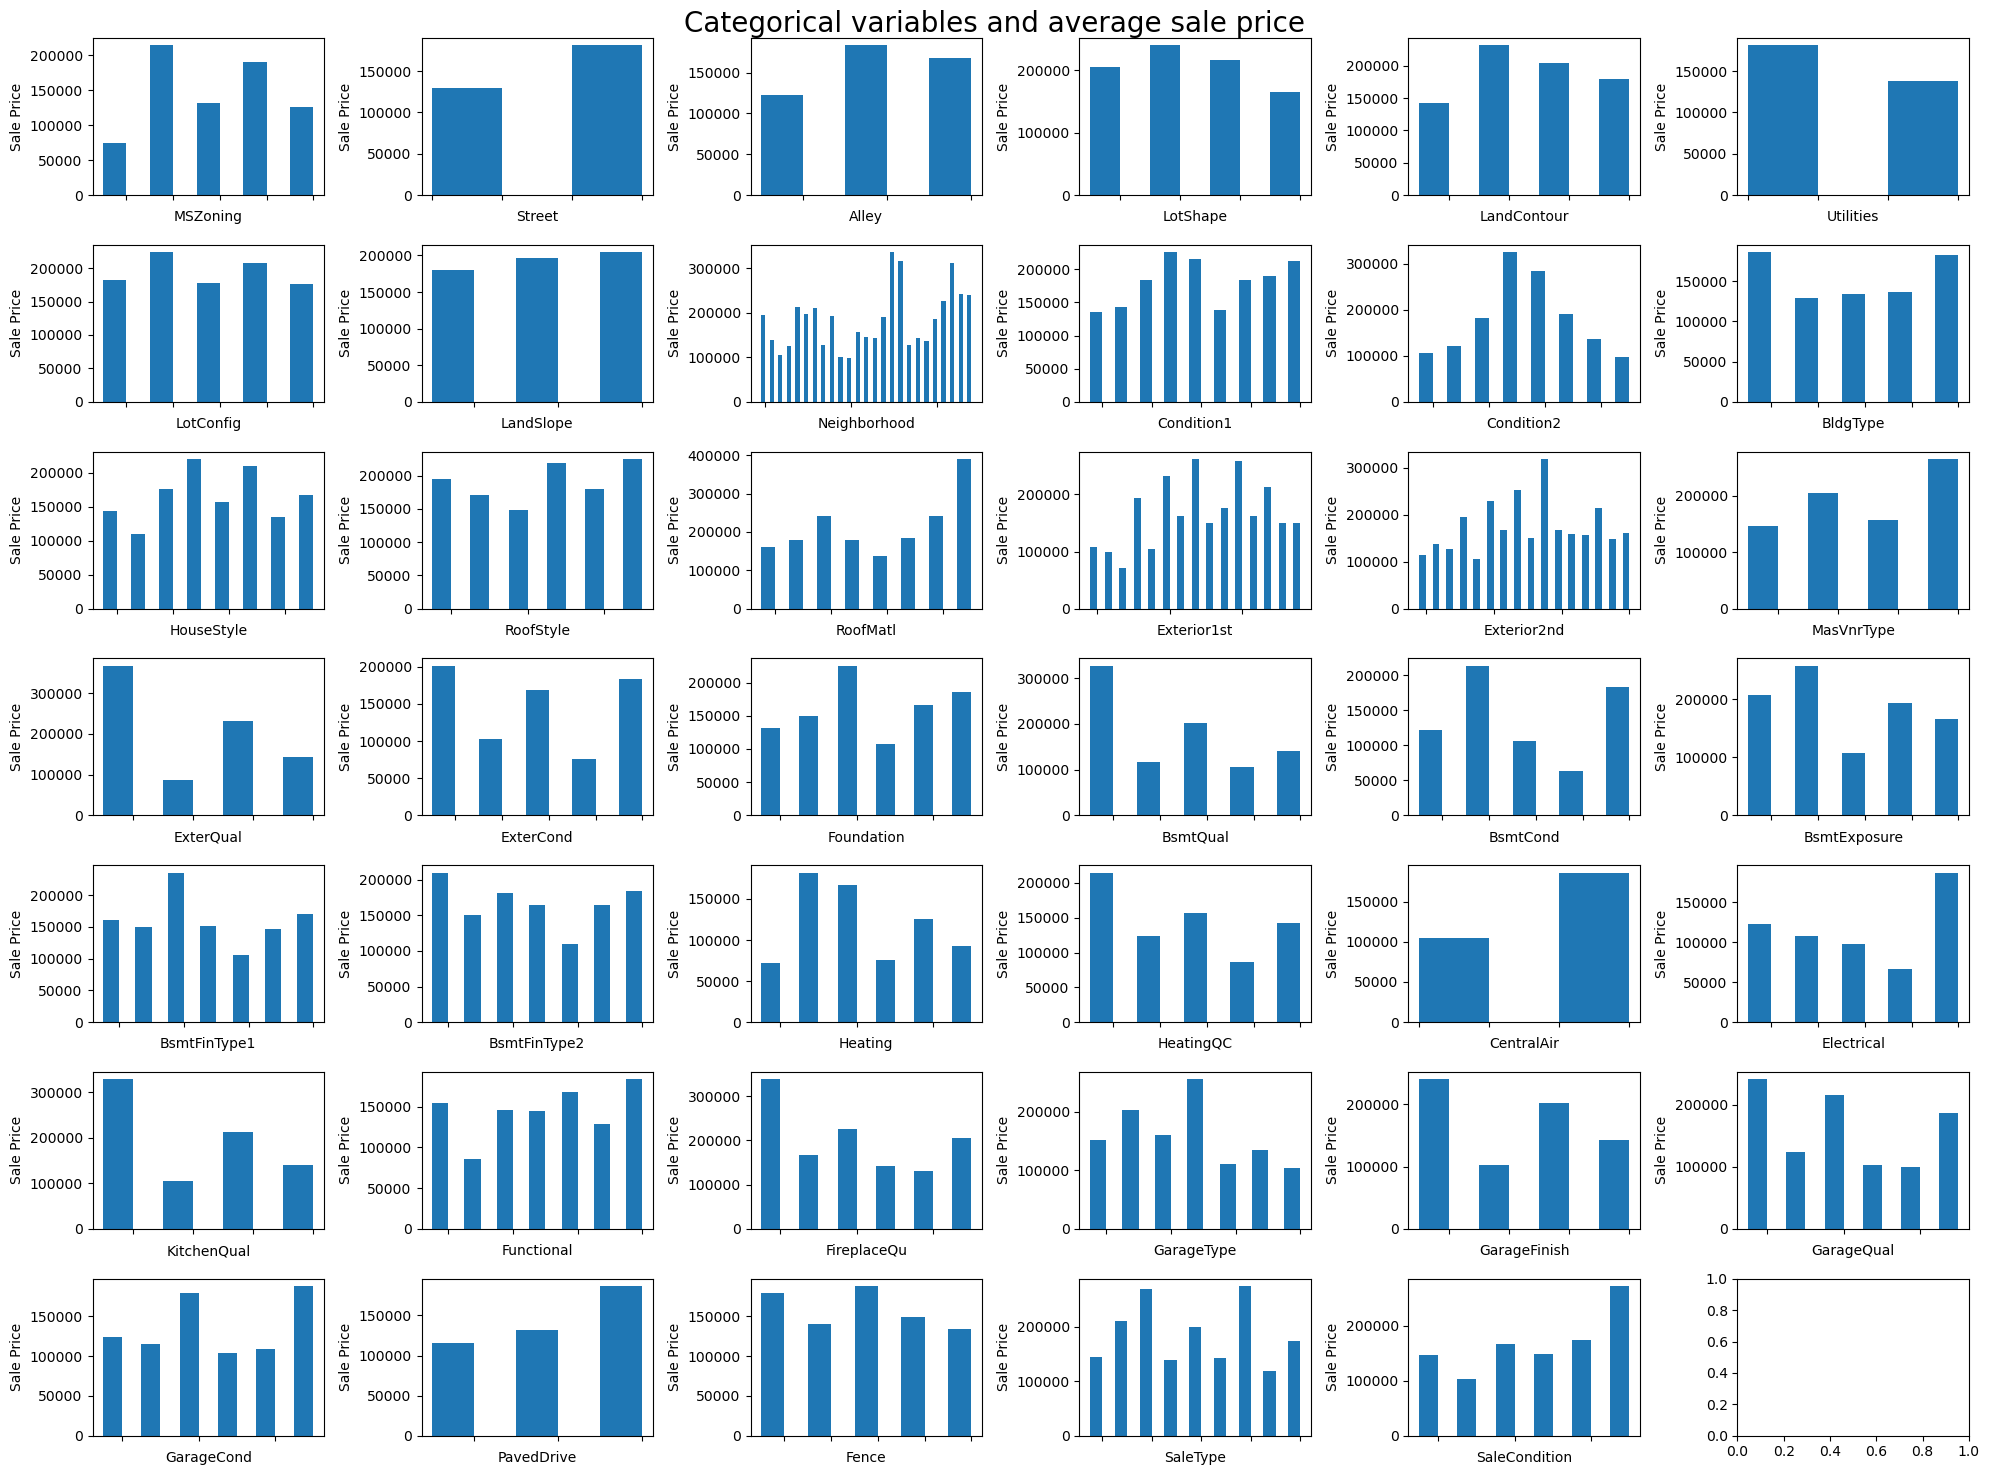

In [52]:
# categorical exploration
cat_vars = pd.concat([train.loc[:, train.dtypes == type(train.dtypes[2])], train.SalePrice], axis = 1)
n_cols = cat_vars.shape[1]

# plots
num_row = 7
num_col = 6
fig, ax = plt.subplots(num_row, num_col, figsize = (20, 15))

count_k = 0
for i in range(num_row):
    for j in range(num_col):

        # each df
        var_i = cat_vars.columns[count_k]

        if var_i == "SalePrice":
            pass 
        else:

            df_i = pd.DataFrame(cat_vars.groupby(var_i)['SalePrice'].mean())
            df_i.reset_index(inplace = True)

            # create plot i
            x = np.arange(df_i.shape[0])
            width = .5

            # set the bars
            ax[i][j].bar(x - width / 2, df_i.SalePrice, width, label = "x")
            ax[i][j].set_xlabel(var_i)
            ax[i][j].set_ylabel("Sale Price")
            #ax[i][j].set_xticklabels(df_i[var_i], rotation = 90)
            ax[i][j].set_xticklabels("")
            
            count_k += 1

fig.suptitle("Categorical variables and average sale price", size=20)
fig.tight_layout()

print("")

## Feature Engineering

Simplifying the data for any future model we use

In [53]:
# keep adapting this formula to change how we feature engineer
def feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))

    # deciding to drop a few features for various reasons
    vars_to_drop = [
        "LowQualFinSF", # hardly any variation
        "LandSlope", # not much variation
        "PoolArea", # binarized above
        "MiscVal", # not much variation
        "Utilities", # only 1 obs in training data different from regular
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    # get log of sale price which will be our actual response variable
    if test_data:
        pass 
    else:
        df['LogSalePrice'] = np.log(df.SalePrice)

    return df

In [54]:
# run function on test and train
train = feature_eng(train)
test = feature_eng(test, test_data=True)

# Modeling

## Linear Model

Function to prep data for a very baseline linear model

In [55]:
def lm_df_clean(df):

    lm_vars = ['LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
              'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
              'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms']

    df = pd.get_dummies(df[lm_vars], 
        columns = ['Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
        drop_first=True)
    
    return df

Get train/test data all ready

In [67]:
X_train = lm_df_clean(train)
X_test = lm_df_clean(test)
Y_train = train.SalePrice
Y_test = sample.SalePrice

Baseline linear model is very overfit

In [57]:
# Decent R2
from sklearn.linear_model import LinearRegression
lr_1 = LinearRegression(fit_intercept=True)
lr_1.fit(X_train,Y_train)

print("Fit on training data: {:.3f}".format(lr_1.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_1.score(X_test ,Y_test)))


Fit on training data: 0.850
Fit on testing data: -17.593


Same feature set with a baseline RandomForest is also overfit

In [58]:
dt = DecisionTreeRegressor(random_state = 0)
dt.fit(X_train, Y_train)

print("Fit on training data: {:.3f}".format(dt.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(dt.score(X_test ,Y_test)))

Fit on training data: 1.000
Fit on testing data: -18.977


Basic linear model with single coefficient

In [86]:
#Simplest possible model - Chose variable with highest coefficient from initial correlation matrix

X_train_2 = train.drop(train.columns.difference(['OverallQual']), 1)
X_test_2 = test.drop(test.columns.difference(['OverallQual']), 1)
Y_train = train.SalePrice
Y_test = sample.SalePrice

lr_2 = LinearRegression(fit_intercept=True)
lr_2.fit(X_train_2,Y_train)

print("Fit on training data: {:.3f}".format(lr_2.score(X_train_2,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_2.score(X_test_2 ,Y_test)))

Fit on training data: 0.626
Fit on testing data: -14.882


## Additional EDA and Feature Engineering to Explore

* Identifying and addressing any outliers
* Identify data that doesn't generalize well
 * ex. year built -> house age 
* Combine data?
 * ex. Total house square footage